In [1]:
from __future__ import division
import statsmodels.formula.api as smf
from numpy import transpose as T
import matplotlib.pyplot as plt
from collections import Counter
import statsmodels.api as sm
import scipy.stats as stats
import sklearn.cluster
import datetime as dt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy
import sys
import os
sys.stdout.write('.')
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

CONDIR = os.environ.get("CONDIR")

.

# Preparation

### Read in data

In [2]:
global_signal_regression = False
gsr = '' if global_signal_regression else '_gsr'
title = 'no GSR' if global_signal_regression else 'with GSR'
connectomes = np.load(os.path.join(CONDIR,'derivatives/connectomes%s.npy'%gsr))
results = pd.read_csv(os.path.join(CONDIR,'derivatives/connectome_results.csv'))
results = results.drop('Unnamed: 0',axis=1)
statT_gsr = np.load(os.path.join(CONDIR,'derivatives/statT_mixed_gsr.npy'))
statT = np.load(os.path.join(CONDIR,'derivatives/statT_mixed.npy'))
statP_gsr = np.load(os.path.join(CONDIR,'derivatives/statP_mixed_gsr.npy'))
statP = np.load(os.path.join(CONDIR,'derivatives/statP_mixed.npy'))

In [3]:
# subset results where QA is passed
QAid = np.where(np.logical_and(results.MRIQC_pass==1, results.MOTION_pass==1))[0]
results = results.iloc[QAid]
results['patient_bin'] = ['True' if x==888 else 'False' for x in results['patient']]
results.reset_index()
connectomes = connectomes[:,:,QAid]

### Prepare labels and functions for connectome figures

In [4]:
def gordon_figure(correlation,limits,labelnames,title):
    unique_labels = np.unique(labelnames)
    labels_num = [np.where(unique_labels==x)[0].tolist()[0] for val,x in enumerate(labelnames)]
    major_ticks = [np.min(np.where(np.array(labels_num)==x))-1 for x in range(len(np.unique(labelnames)))]
    minor_ticks = [np.mean(np.where(np.array(labels_num)==x))-1 for x in range(len(np.unique(labelnames)))]
    fig = plt.figure(figsize=(6, 5), dpi= 100, facecolor='w', edgecolor='k')
    ax = fig.add_subplot(111)
    ax1 = ax.imshow(correlation,cmap = "PuOr_r",vmin=limits[0],vmax=limits[1],aspect='auto',interpolation='nearest')
    ax.set_title(title)
    ax.set_xticks(major_ticks,minor=False)
    ax.set_xticks(minor_ticks,minor=True)
    ax.set_xticklabels(unique_labels,minor=True,rotation=90)
    ax.set_xticklabels(unique_labels,minor=False,visible=False)
    ax.set_yticks(major_ticks,minor=False)
    ax.set_yticks(minor_ticks,minor=True)
    ax.set_yticklabels(unique_labels,minor=True)
    ax.set_yticklabels(unique_labels,minor=False,visible=False)
    plt.colorbar(ax1)
    plt.tight_layout()


# Look at differences between psychosis and HC with classical statistics

## Parcelwise

The figure below shows a comparison of the distribution of T-values with or without global signal regression.

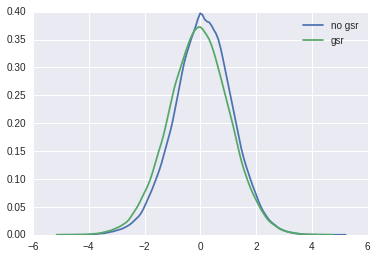

In [5]:
sns.distplot(statT.flatten(),hist=False,label='no gsr')
sns.distplot(statT_gsr.flatten(),hist=False,label="gsr")

#### T-statistics (from mixed model) measuring edgewise connectivity **_WITH GLOBAL SIGNAL REGRESSION_**

In [6]:
labelsfile = os.path.join(os.environ.get("CODEDIR"),"04_connectome/utils/Parcels.xlsx")
labeltable = pd.read_excel(labelsfile)
subprob = range(333,353)
cort = range(353,382)
order = np.argsort(labeltable.Community).tolist()+subprob+cort
labelnames = list(labeltable.Community[order][:333])+['subcort']*20+['cerebellum']*27
labels = np.unique(labelnames)
labelnames_unsorted = list(labeltable.Community)+['subcort']*20+['cerebellum']*27

mncor = np.mean(connectomes,axis=2)
mncor = mncor[:,order]
mncor = mncor[order,:]

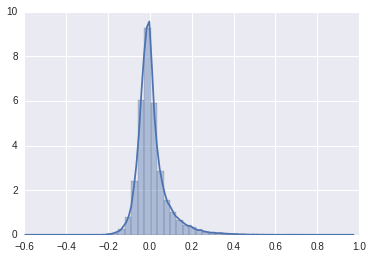

In [7]:
sns.distplot(mncor.flatten())

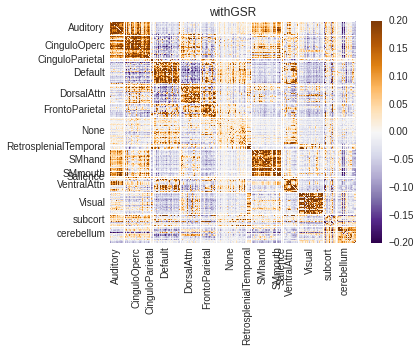

In [8]:
gordon_figure(mncor,limits=[-0.2,0.2],labelnames=labelnames,title="withGSR")

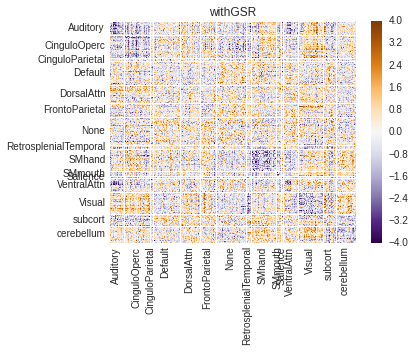

In [9]:
meancor = statT_gsr
cor_gsr = meancor[:,order]
cor_gsr = cor_gsr[order,:]

gordon_figure(cor_gsr,limits=[-4,4],labelnames=labelnames,title="withGSR")

#### T-statistics (from mixed model) measuring edgewise connectivity **_WITHOUT GLOBAL SIGNAL REGRESSION_**

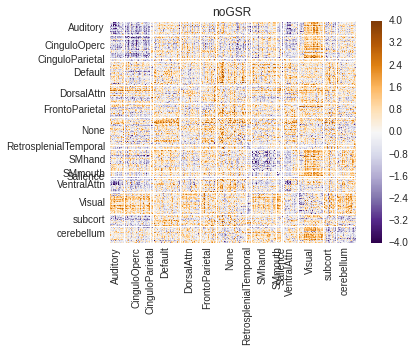

In [10]:
meancor = statT
cor = meancor[:,order]
cor = cor[order,:]
gordon_figure(cor,limits=[-4,4],labelnames=labelnames,title="noGSR")


In [11]:
upid = np.triu_indices(statT.shape[0])

cor = statT[:,order]
cor = cor[order,:]
pvals = statP[upid]
hlp = np.argsort(pvals)/len(pvals)*0.05
bhpthres = np.max(pvals[pvals<hlp])
bhidx = np.where(statP<bhpthres)
bhthres = np.zeros(statP.shape)
bhthres[bhidx]=cor[bhidx]

cor_gsr = statT_gsr[:,order]
cor_gsr = cor_gsr[order,:]
pvals = statP_gsr[upid]
hlp = np.argsort(pvals)/len(pvals)*0.05
bhpthres_gsr = np.max(pvals[pvals<hlp])
bhidx = np.where(statP_gsr<bhpthres_gsr)
bhthres_gsr = np.zeros(statP.shape)
bhthres_gsr[bhidx]=cor_gsr[bhidx]

cor_gsr = statT_gsr[:,order]
cor_gsr = cor_gsr[order,:]
pvals = statP_gsr[upid]
fwethres_gsr = 0.05/len(pvals)
fweidx = np.where(statP_gsr<fwethres_gsr)
fwethres_gsr = np.zeros(statP.shape)
fwethres_gsr[fweidx]=cor_gsr[fweidx]

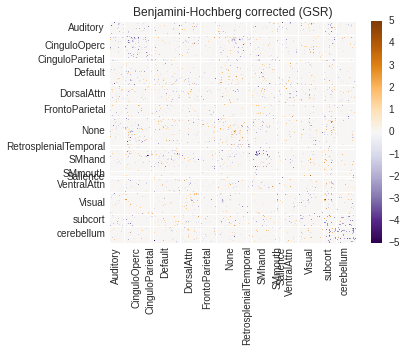

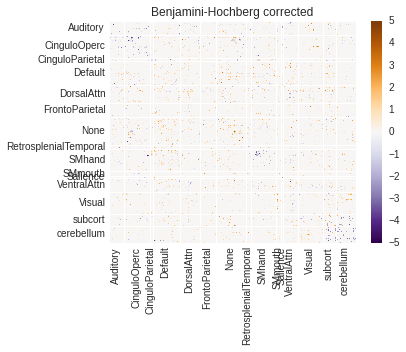

In [12]:
gordon_figure(bhthres_gsr,limits=[-5,5],labelnames=labelnames,title="Benjamini-Hochberg corrected (GSR)")
gordon_figure(bhthres,limits=[-5,5],labelnames=labelnames,title="Benjamini-Hochberg corrected")

In [13]:
statT_gsr = np.load(os.path.join(CONDIR,'derivatives/statT_mixed_gsr_noqc.npy'))
statT = np.load(os.path.join(CONDIR,'derivatives/statT_mixed_noqc.npy'))
statP_gsr = np.load(os.path.join(CONDIR,'derivatives/statP_mixed_gsr_noqc.npy'))
statP = np.load(os.path.join(CONDIR,'derivatives/statP_mixed_noqc.npy'))

In [14]:
upid = np.triu_indices(statT.shape[0])

cor = statT[:,order]
cor = cor[order,:]
pvals = statP[upid]
hlp = np.argsort(pvals)/len(pvals)*0.05
bhpthres = np.max(pvals[pvals<hlp])
bhidx = np.where(statP<bhpthres)
bhthres = np.zeros(statP.shape)
bhthres[bhidx]=cor[bhidx]

cor_gsr = statT_gsr[:,order]
cor_gsr = cor_gsr[order,:]
pvals = statP_gsr[upid]
hlp = np.argsort(pvals)/len(pvals)*0.05
bhpthres_gsr = np.max(pvals[pvals<hlp])
bhidx = np.where(statP_gsr<bhpthres_gsr)
bhthres_gsr = np.zeros(statP.shape)
bhthres_gsr[bhidx]=cor_gsr[bhidx]

cor_gsr = statT_gsr[:,order]
cor_gsr = cor_gsr[order,:]
pvals = statP_gsr[upid]
fwethres_gsr = 0.05/len(pvals)
fweidx = np.where(statP_gsr<fwethres_gsr)
fwethres_gsr = np.zeros(statP.shape)
fwethres_gsr[fweidx]=cor_gsr[fweidx]

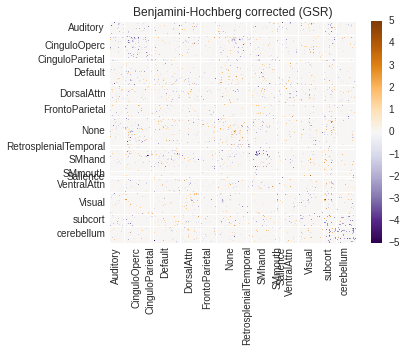

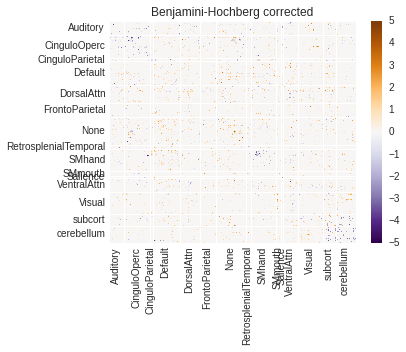

In [15]:
gordon_figure(bhthres_gsr,limits=[-5,5],labelnames=labelnames,title="Benjamini-Hochberg corrected (GSR)")
gordon_figure(bhthres,limits=[-5,5],labelnames=labelnames,title="Benjamini-Hochberg corrected")